In [1]:
#confidence_levels.ipynb 
# 
#by Joe Hahn
#joe.hahn@oracle.com
#18 July 2018
#
#plot the MLP model's confidence levels

In [2]:
#set system parameters
x_half_width = 0.5
radius = 3.5
box_half_width = 7.1
jitter = 1.0
rn_seed = 15
initial_id = 0

In [3]:
#generate sample of xo data
N_dots = 20000
import numpy as np
rn_state = np.random.RandomState(seed=rn_seed)
from helper_fns import *
xo = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
xo.tail()

,id,x,y,r,angle,class,X_score,O_score,B_score
record,,,,,,,,,
19995,19995,2.977793,-0.672306,3.052744,-0.222050,X,1.0,0.0,0.0
19996,19996,3.961754,-3.902603,5.561097,-0.777877,X,1.0,0.0,0.0
19997,19997,-2.101629,4.225901,4.719649,2.032298,B,0.0,0.0,1.0
19998,19998,-7.871982,-0.446506,7.884634,-3.084932,B,0.0,0.0,1.0
19999,19999,-4.285127,0.582346,4.324516,3.006521,B,0.0,0.0,1.0


In [4]:
#extract x-features and y = target variables
x_cols = ['x', 'y']
y_cols = ['O_score', 'X_score', 'B_score']
N_classes = len(y_cols)
print 'N_classes = ', N_classes
x = xo[x_cols].values
y = xo[y_cols].values
print x.shape, y.shape

N_classes =  3
(20000, 2) (20000, 3)


In [5]:
#load mlp model
from keras.models import load_model
model = load_model('mlp_model.h5')

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
#generate predictions and stash results in xo dataframe
y_pred = model.predict(x)
import pandas as pd
cols = [col + '_pred' for col in y_cols]
y_pred_df = pd.DataFrame(data=y_pred, columns=cols)
#normalize class scores
xo['sum'] = 0.0
for col in y_pred_df.columns:
    xo[col] = y_pred_df[col]
    xo['sum'] += y_pred_df[col]
for col in y_pred_df.columns:
    xo[col] /= xo['sum']
xo['sum'] = 0.0
for col in y_pred_df.columns:
    xo['sum'] += xo[col]
cols = y_pred_df.columns
xo['class_score'] = xo.apply(lambda x: x[cols].max(), axis=1)
xo['class_pred'] = xo.apply(lambda x: cols[x[cols].values.argmax()][0], axis=1)
cols = ['id', 'x', 'y', 'class', 'class_score', 'class_pred']
xo[cols].head(10)

,id,x,y,class,class_score,class_pred
record,,,,,,
0,0,3.911457,3.452269,X,0.621237,X
1,1,-2.358122,-7.449542,B,0.927869,B
2,2,0.675741,3.421617,O,0.731725,O
3,3,6.315397,4.384856,B,0.535896,B
4,4,-5.474637,2.024103,B,0.768726,B
5,5,2.039149,0.688727,X,0.686817,O
6,6,-4.073560,-7.113992,B,0.712481,B
7,7,5.572713,-0.108814,B,0.839047,B
8,8,-4.463955,5.396672,X,0.710117,X


In [7]:
#prep plots
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(font_scale=1.5, font='DejaVu Sans')

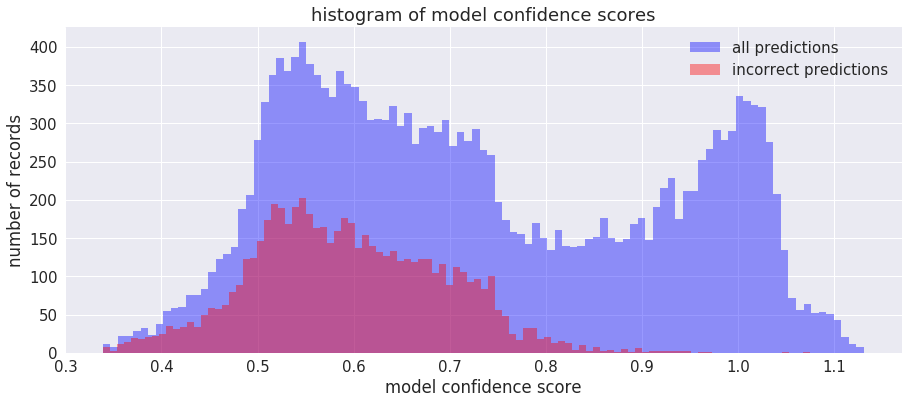

In [8]:
#histogram model confidence
N_bins = 101
fig, ax = plt.subplots(1,1, figsize=(15, 6))
#historgram all predictions
xp = xo.class_score
p = sns.distplot(xp, bins=N_bins, ax=ax, kde=False, color='blue', label='all predictions')
#histogram incorrect predictions
idx = (xo['class'] != xo['class_pred'])
xp = xo[idx].class_score
p = sns.distplot(xp, bins=N_bins, ax=ax, kde=False, color='red', label='incorrect predictions')
p = ax.set_title('histogram of model confidence scores')
p = ax.set_xlabel('model confidence score')
p = ax.set_ylabel('number of records')
p = ax.legend()
ax.figure.savefig('figs/mlp_confidence_scores.png')

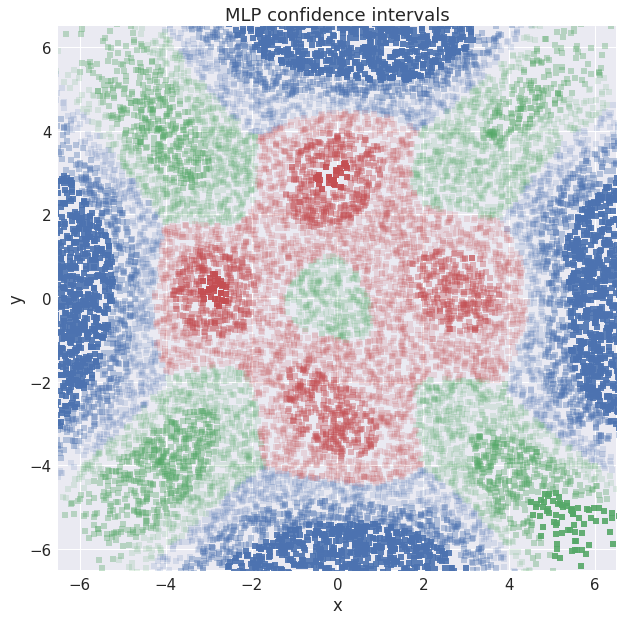

In [9]:
#scatterplot showing model's predicted decision boundaries
df = xo
xy_rng = (-6.5, 6.5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
clr_idx = -1
#B predictions having class_score>0.85
lbl = 'B'
clr_idx += 1
clr = colors = plt.rcParams["axes.prop_cycle"].by_key()["color"][clr_idx]
idx = (df['class_pred'] == lbl) & (df['class_score'] > 0.8)
p = sns.regplot(df[idx].x, df[idx].y, ax=ax, fit_reg=False, color=clr, scatter_kws={'alpha':0.9, 's': sz}, marker='s')
#B predictions having 0.7>class_score>0.85
idx = (df['class_pred'] == lbl) & (df['class_score'] > 0.65) & (df['class_score'] < 0.8)
p = sns.regplot(df[idx].x, df[idx].y, ax=ax, fit_reg=False, color=clr, scatter_kws={'alpha':0.35, 's': sz}, marker='s')
#B predictions having class_score<0.7
idx = (df['class_pred'] == lbl) & (df['class_score'] < 0.65)
p = sns.regplot(df[idx].x, df[idx].y, ax=ax, fit_reg=False, color=clr, scatter_kws={'alpha':0.15, 's': sz}, marker='s')
#X predictions having class_score>0.7
lbl = 'X'
clr_idx += 1
clr = colors = plt.rcParams["axes.prop_cycle"].by_key()["color"][clr_idx]
idx = (df['class_pred'] == lbl) & (df['class_score'] > 0.8)
p = sns.regplot(df[idx].x, df[idx].y, ax=ax, fit_reg=False, color=clr, scatter_kws={'alpha':0.9, 's': sz}, marker='s')
#X predictions having 0.5>class_score>0.7
idx = (df['class_pred'] == lbl) & (df['class_score'] > 0.65) & (df['class_score'] < 0.8)
p = sns.regplot(df[idx].x, df[idx].y, ax=ax, fit_reg=False, color=clr, scatter_kws={'alpha':0.35, 's': sz}, marker='s')
#X predictions having class_score<0.5
idx = (df['class_pred'] == lbl) & (df['class_score'] < 0.65)
p = sns.regplot(df[idx].x, df[idx].y, ax=ax, fit_reg=False, color=clr, scatter_kws={'alpha':0.15, 's': sz}, marker='s')
#O predictions having class_score>0.85
lbl = 'O'
clr_idx += 1
clr = colors = plt.rcParams["axes.prop_cycle"].by_key()["color"][clr_idx]
idx = (df['class_pred'] == lbl) & (df['class_score'] > 0.8)
p = sns.regplot(df[idx].x, df[idx].y, ax=ax, fit_reg=False, color=clr, scatter_kws={'alpha':0.9, 's': sz}, marker='s')
#X predictions having 0.7>class_score>0.85
idx = (df['class_pred'] == lbl) & (df['class_score'] > 0.65) & (df['class_score'] < 0.8)
p = sns.regplot(df[idx].x, df[idx].y, ax=ax, fit_reg=False, color=clr, scatter_kws={'alpha':0.35, 's': sz}, marker='s')
#X predictions having class_score<0.7
idx = (df['class_pred'] == lbl) & (df['class_score'] < 0.65)
p = sns.regplot(df[idx].x, df[idx].y, ax=ax, fit_reg=False, color=clr, scatter_kws={'alpha':0.15, 's': sz}, marker='s')
p = ax.set_title('MLP confidence intervals')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
plt.savefig('figs/mlp_confidence_boundary.png')